In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from tqdm import tqdm

from bnn import DummyBNN
from adaptive_sghmc import AdaptiveSGHMC
from sghmc import SGHMC

%matplotlib inline

tfd = tfp.distributions
tfl = tf.keras.layers

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)

#plt.rc("text", usetex=True)
plt.rc("font", size=32.0, family="serif")
plt.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

In [2]:
def f(x):
    return np.sinc(x * 10. - 5.)

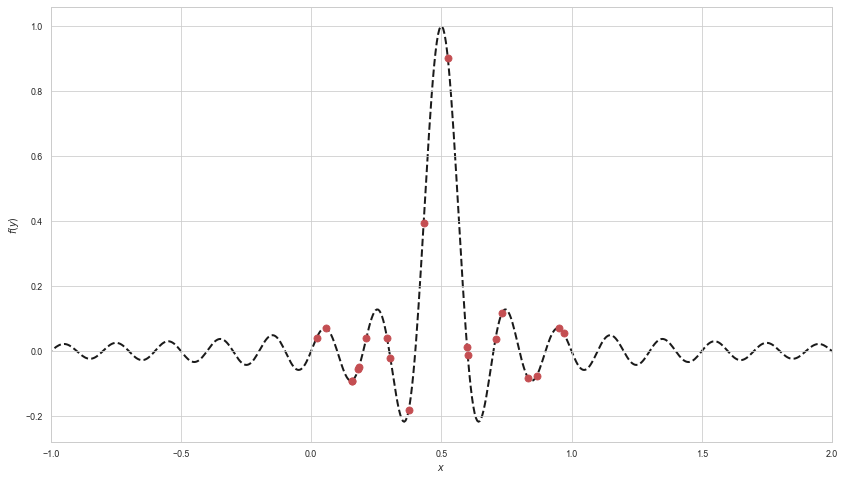

In [3]:
rng = np.random.RandomState(42)

num_points = 20

x = rng.rand(num_points).astype(np.float32)
y = f(x)

grid = np.linspace(-2., 3., 1000).astype(np.float32)
fvals = f(grid)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=1, s=50)

ax.set_xlim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.show()

In [4]:
bnn = DummyBNN()
bnn.build(input_shape=(None, 1))

In [5]:
@tf.function
def train_step(model, batch, labels):

    with tf.GradientTape() as tape:
        
        data_size = tf.cast(num_points, tf.float32)
        
        pred = model(batch)
        
        likelihood = tfd.Normal(loc=pred, scale=tf.exp(0.5 * model.likelihood_log_var))
        log_likelihood = tf.reduce_mean(likelihood.log_prob(labels))
        
        var_prior_log_prob = model.var_prior.log_prob(tf.exp(model.likelihood_log_var)) / data_size
        
        weight_prior_log_prob = model.weight_prior_log_prob() / data_size
        
        loss = -(log_likelihood + weight_prior_log_prob + var_prior_log_prob)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return pred, log_likelihood, var_prior_log_prob, weight_prior_log_prob

In [6]:
batch_size = num_points
iterations = 10000
keep_every = 50
burnin = 3000
learning_rate = 3e-3
momentum_decay = 0.05

log_every = 1000

x_mean, x_var = tf.nn.moments(tf.convert_to_tensor(x), axes=[0])
x_std = tf.sqrt(x_var)
y_mean, y_var = tf.nn.moments(tf.convert_to_tensor(y), axes=[0])
y_std = tf.sqrt(y_var)

x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

ds = tf.data.Dataset.from_tensor_slices((x_normalized[:, None], y_normalized[:, None]))
ds = ds.shuffle(500).repeat().batch(batch_size).prefetch(16)

optimizer = {
    "adaptive_sghmc": AdaptiveSGHMC(learning_rate=learning_rate,
                          burnin=burnin,
                          data_size=num_points,
                          momentum_decay=momentum_decay),
    
    "sghmc": SGHMC(learning_rate=1e-6,
                   data_size=num_points,
                   momentum_decay=momentum_decay),
    
    "adam": tf.optimizers.Adam(learning_rate=1e-3),
}["adaptive_sghmc"]

In [7]:
weight_samples = []

i = 0

for batch, labels in tqdm(ds.take(iterations), total=iterations):

    i = i + 1
    
    # Resample scale hyperparameters every epoch

    pred, ll, vplp, wplp = train_step(bnn,
                                      batch, 
                                      labels)
    
    if i >= burnin and i % keep_every == 0:
        weight_samples.append(bnn.get_weights())
        
    if i % log_every == 0:
        mse = tf.reduce_mean(tf.math.squared_difference(pred, labels[:, None]))
        
        print(f"iteration {i}: "
              f"MSE: {mse}, "
              f"LL: {ll}, "
              f"weight prior LL: {wplp}, "
              f"var prior LL: {vplp}")

 10%|█         | 1019/10000 [00:11<01:17, 115.56it/s]

iteration 1000: MSE: 1.3474421501159668, LL: -203.43258666992188, weight prior LL: -0.05294538289308548, var prior LL: -14.939203262329102


 20%|██        | 2010/10000 [00:20<01:13, 108.62it/s]

iteration 2000: MSE: 1.8392900228500366, LL: -23.90595817565918, weight prior LL: -0.06072886660695076, var prior LL: -17.80042839050293


 30%|███       | 3020/10000 [00:29<00:59, 118.15it/s]

iteration 3000: MSE: 1.9394725561141968, LL: -10.951521873474121, weight prior LL: -0.108705535531044, var prior LL: -20.461530685424805


 40%|████      | 4021/10000 [00:37<00:47, 126.28it/s]

iteration 4000: MSE: 2.178792715072632, LL: -16.16861343383789, weight prior LL: -0.16299425065517426, var prior LL: -20.91123390197754


 50%|█████     | 5017/10000 [00:45<00:39, 126.26it/s]

iteration 5000: MSE: 1.9660918712615967, LL: -11.33586597442627, weight prior LL: -0.22029630839824677, var prior LL: -20.231767654418945


 60%|██████    | 6012/10000 [00:52<00:32, 124.42it/s]

iteration 6000: MSE: 1.93985915184021, LL: -9.920352935791016, weight prior LL: -0.28408345580101013, var prior LL: -20.677749633789062


 70%|███████   | 7020/10000 [01:00<00:23, 128.64it/s]

iteration 7000: MSE: 2.131923198699951, LL: -59.17554473876953, weight prior LL: -0.36515679955482483, var prior LL: -18.130281448364258


 80%|████████  | 8015/10000 [01:10<00:16, 123.95it/s]

iteration 8000: MSE: 2.0160810947418213, LL: -2.8187663555145264, weight prior LL: -0.35886886715888977, var prior LL: -20.395503997802734


 90%|█████████ | 9018/10000 [01:17<00:07, 128.34it/s]

iteration 9000: MSE: 2.0319135189056396, LL: -10.498025894165039, weight prior LL: -0.41014227271080017, var prior LL: -18.149648666381836


100%|██████████| 10000/10000 [01:25<00:00, 117.32it/s]

iteration 10000: MSE: 2.039945125579834, LL: -17.4827823638916, weight prior LL: -0.47100257873535156, var prior LL: -18.781538009643555


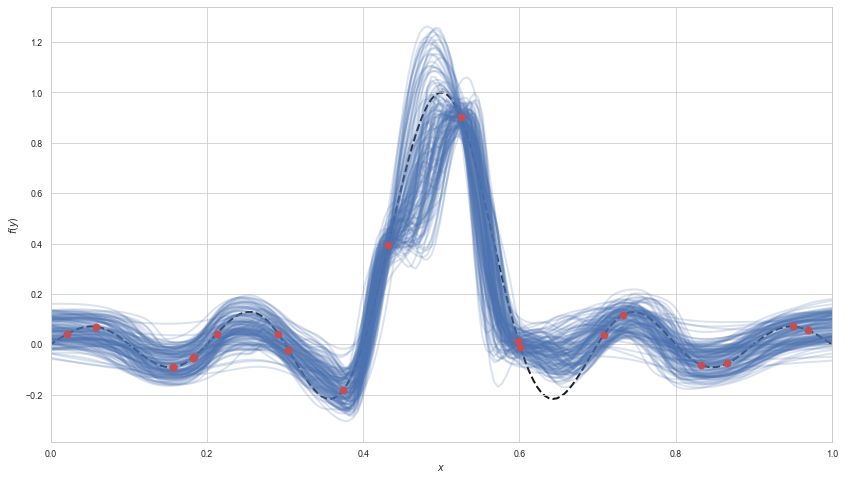

In [8]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

all_preds = []

for weights in weight_samples:
    
    bnn.set_weights(weights)
    
    pred = bnn((grid[:, None] - x_mean) / x_std).numpy()[:, 0]
    pred = y_std * pred + y_mean
    
    ax.plot(grid, pred, c='b', alpha=0.2, zorder=1)
    
    all_preds.append(pred)

all_preds = tf.stack(all_preds, axis=0)

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=2, s=50)

ax.set_xlim([-0., 1.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.show()

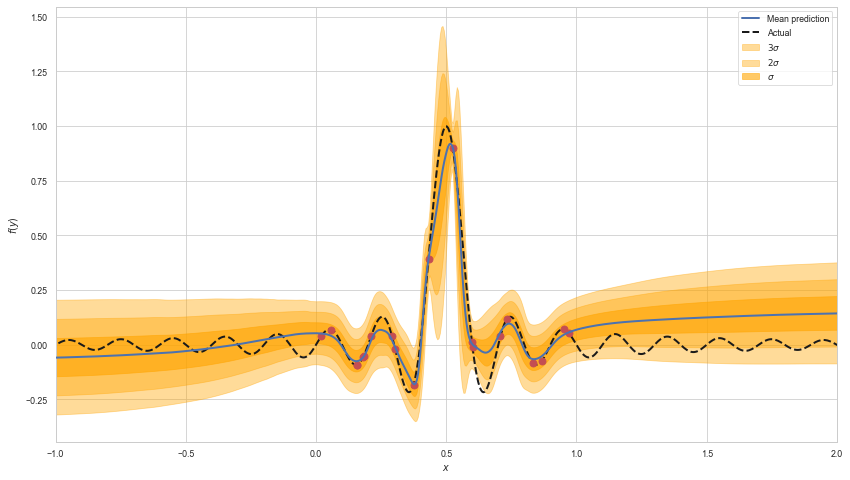

In [10]:
mean_pred, var_pred = tf.nn.moments(all_preds, axes=[0])

fig, ax = plt.subplots(figsize=(14, 8))

std_pred = tf.sqrt(var_pred)

ax.plot(grid, mean_pred, linestyle='-', c='b', zorder=4, label="Mean prediction")
ax.fill_between(grid, 
                mean_pred + 3. * std_pred, 
                mean_pred - 3. * std_pred, 
                alpha=0.4, label="$3\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + 2. * std_pred, 
                mean_pred - 2. * std_pred, 
                alpha=0.4, label="$2\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + std_pred, 
                mean_pred - std_pred, 
                alpha=0.6, label="$\sigma$", color='orange')

ax.plot(grid, fvals, linestyle='--', c='k', zorder=2, label="Actual")
ax.scatter(x, y, marker='o', c='r', zorder=3, s=50)

ax.set_xlim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

ax.legend()

plt.show()